In [ ]:
import os
import random
import pandas as pd

dataset_path = "./"

files = []

for clase in os.listdir(dataset_path):
    clase_path = os.path.join(dataset_path, clase)
    if not os.path.isdir(clase_path):
        continue

    imgs = [
        os.path.join(clase_path, f)
        for f in os.listdir(clase_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    if len(imgs) == 0:
        continue

    random.shuffle(imgs)
    mitad = imgs[: len(imgs)//2 ]   # 50%

    for img in mitad:
        files.append((img, clase))

df = pd.DataFrame(files, columns=["filepath", "label"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Total imágenes seleccionadas (50%):", len(df))
df.head()


Total imágenes seleccionadas (50%): 7120


,filepath,label
0,./Happy\cropped_emotions.505900.png,Happy
1,./Angry\cropped_emotions.231793~angry.png,Angry
2,./Happy\cropped_emotions.505841.png,Happy
3,./Happy\cropped_emotions.506055.png,Happy
4,./Neutral\cropped_emotions.277871f.png,Neutral


In [ ]:
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

print("Train:", len(train_df))
print("Validation:", len(val_df))


Train: 5696
Validation: 1424


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (64, 64)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Clases:", train_gen.class_indices)


Found 5696 validated image filenames belonging to 5 classes.
Found 1424 validated image filenames belonging to 5 classes.
Clases: {'Angry': 0, 'Happy': 1, 'Neutral': 2, 'Sad': 3, 'Surprise': 4}


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\Lander\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,429 (669.64 KB)

 Trainable params: 171,429 (669.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


c:\Users\Lander\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 368ms/step - accuracy: 0.2958 - loss: 1.5009 - val_accuracy: 0.3750 - val_loss: 1.4148
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 30s 168ms/step - accuracy: 0.3831 - loss: 1.3848 - val_accuracy: 0.4129 - val_loss: 1.3296
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - accuracy: 0.4424 - loss: 1.2957 - val_accuracy: 0.5323 - val_loss: 1.1523
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 31s 173ms/step - accuracy: 0.4925 - loss: 1.2035 - val_accuracy: 0.5527 - val_loss: 1.1009
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.5183 - loss: 1.1528 - val_accuracy: 0.5576 - val_loss: 1.0769
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 30s 170ms/step - accuracy: 0.5393 - loss: 1.1077 - val_accuracy: 0.5660 - val_loss: 1.0191
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.5604 - loss: 1.0582 - val_accuracy: 0.6046 - val_loss: 0.9566
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 33s 186ms/step - accuracy: 0.5750 - loss: 1

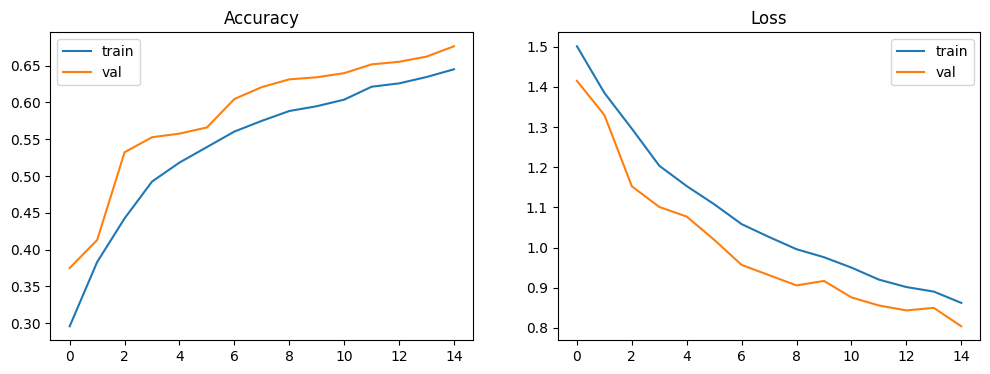

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["train","val"])

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(["train","val"])

plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step


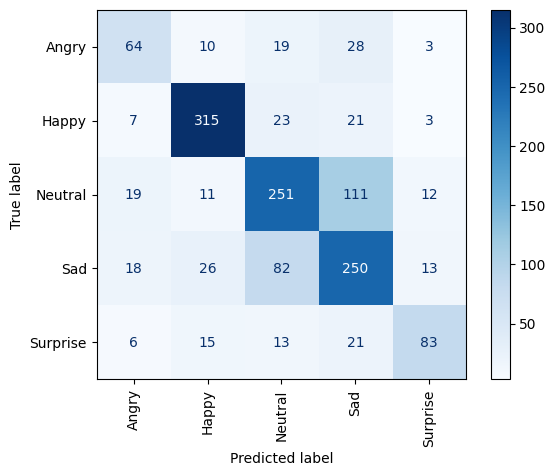

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones del modelo
val_gen.reset()  # Reiniciar el generador para asegurar que se procesen todas las imágenes
predictions = model.predict(val_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener etiquetas reales
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Crear matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues", xticks_rotation="vertical")

In [ ]:
model.save("./cnn_moodmirror_64px_50dataset.h5")


In [ ]:
import numpy as np
import cv2

# Ruta de prueba
test_path = "./test2.jpg"  # cámbiala

img = cv2.imread(test_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, IMG_SIZE)
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
idx = pred.argmax()

# Mapeo índice → nombre de clase
idx_to_class = {v:k for k,v in train_gen.class_indices.items()}

print("Predicción:", idx_to_class[idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicción: Happy
